* Ev Fiyatları verilerini Kaggle'dan indirin.
* Önceki dersteki modelinizi yeniden uygulayın.
* Aynı model tanımını kullanarak OLS, Lasso, Ridge ve ElasticNet regresyonlarını deneyin. Bu kez, modelleriniz için en iyi hiperparametre değerlerini seçmek için k-fold çapraz doğrulama yapmanız gerekir. Hangi model en iyisidir? Açıklayın?

**Model 3**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sts
import statsmodels.api as sm
import warnings

from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tsa.stattools import acf

from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import normalize, scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error

from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera, normaltest, bartlett, levene
from sqlalchemy import create_engine

warnings.filterwarnings('ignore')

In [2]:
ev_fiyat = pd.read_csv('./datasets/ev_fiyatlari.csv')

In [3]:
ev_fiyat_nulls = ev_fiyat.isnull().sum().to_frame('nulls')
ev_fiyat_nulls[ev_fiyat_nulls["nulls"]> 0]

,nulls
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


**Null Kayıtların Temizlenmesi:**

In [4]:
# Basement parameters
ev_fiyat.BsmtQual.fillna("NA", inplace = True)
ev_fiyat.BsmtCond.fillna("NA", inplace = True)
ev_fiyat.BsmtExposure.fillna("NA", inplace = True)
ev_fiyat.BsmtFinType1.fillna("NA", inplace = True)
ev_fiyat.BsmtFinType2.fillna("NA", inplace = True)

# Garage Parameters
ev_fiyat.GarageType.fillna("NA", inplace = True)
ev_fiyat.GarageYrBlt.fillna("NA", inplace = True)
ev_fiyat.GarageFinish.fillna("NA", inplace = True)
ev_fiyat.GarageQual.fillna("NA", inplace = True)
ev_fiyat.GarageCond.fillna("NA", inplace = True)


#LotFrontage Parameter
ev_fiyat.LotFrontage.fillna(ev_fiyat.LotFrontage.mean(), inplace = True)

#Alley Parameter
ev_fiyat.Alley.fillna("NA", inplace = True)

#MasVnrType Parameter
ev_fiyat.MasVnrType.fillna("None", inplace = True)

#MasVnrArea Parameter
ev_fiyat.MasVnrArea.fillna(0.0, inplace = True)

#Electrical Parameter
ev_fiyat.Electrical.fillna(ev_fiyat.Electrical.value_counts().index[0], inplace = True) 

#FireplaceQu Parameter
ev_fiyat.FireplaceQu.fillna("NA", inplace = True)

#PoolQC Parameter
ev_fiyat.PoolQC.fillna("NA", inplace = True)

#Fence
ev_fiyat.Fence.fillna("NA", inplace = True)

#MiscFeature
ev_fiyat.MiscFeature.fillna("NA", inplace = True)

In [5]:
del ev_fiyat['GarageYrBlt']
categorical_feature_mask = ev_fiyat.dtypes==object
categorical_cols = ev_fiyat.columns[categorical_feature_mask].tolist()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [7]:
ev_fiyat[categorical_cols] = ev_fiyat[categorical_cols].apply(lambda col: le.fit_transform(col))

In [24]:
Y = ev_fiyat['SalePrice']
X = ev_fiyat[['ExterQual','OverallQual', 
                  'YearRemodAdd', 'Fireplaces','TotalBsmtSF','GrLivArea']]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print('Değişkenler: \n', lrm.coef_)
print('Sabit değer (bias): \n', lrm.intercept_)

Değişkenler: 
 [-18598.58648752  18681.47005408    400.51767399  11692.33072401
     30.31278296     45.30483329]
Sabit değer (bias): 
 -788640.4950737257


In [25]:
import statsmodels.api as sm

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     824.1
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:23:04   Log-Likelihood:                -17462.
No. Observations:                1460   AIC:                         3.494e+04
Df Residuals:                    1453   BIC:                         3.497e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.886e+05   1.17e+05     -6.734      0.000   -1.02e+06   -5.59e+05
ExterQual     -1.86e+04   1922.276     -9.675      0.000   -2.24e+04   -1.48e+04
OverallQual   1.868e+04   1180.942     15.819      0.000    1.64e+04     2.1e+04
YearRemodAdd   400.5177     59.465      6.735      0.000     283.872     517.164
Fireplaces    1.169e+04   1790.974      6.528      0.000    8179.160    1.52e+04
TotalBsmtSF     30.3128      2.795     10.847      0.000      24.831      35.795
GrLivArea       45.3048      2.501     18.113      0.000      40.398      50.211
==============================================================================
Omnibus:                      612.192   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73588.347
Skew:                          -0.930   Prob(JB):                         0.00
Kurtosis:                      37.731   Cond. No.                     3.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
X_egitim, X_test, y_egitim, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [27]:
lrm = LinearRegression()
lrm.fit(X_egitim, y_egitim)

y_egitim_tahmini = lrm.predict(X_egitim)
y_test_tahmini = lrm.predict(X_test)

print("Eğitim kümesindeki gözlem sayısı  : {}".format(X_egitim.shape[0]))
print("Test kümesindeki gözlem sayısı    : {}".format(X_test.shape[0]), "\n")

print("Eğitim kümesindeki R-Kare değeri  : {}".format(lrm.score(X_egitim, y_egitim)))
print("-----Test kümesi istatistikleri---")
print("Test kümesi R-Kare değeri         : {}".format(lrm.score(X_test, y_test)))
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_test_tahmini)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_test_tahmini)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_test_tahmini)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_test_tahmini) / y_test)) * 100))

Eğitim kümesindeki gözlem sayısı  : 1168
Test kümesindeki gözlem sayısı    : 292 

Eğitim kümesindeki R-Kare değeri  : 0.7655157590448299
-----Test kümesi istatistikleri---
Test kümesi R-Kare değeri         : 0.7914573244698969
Ortalama Mutlak Hata (MAE)        : 25545.719823528263
Ortalama Kare Hata (MSE)          : 1510968176.849789
Kök Ortalama Kare Hata (RMSE)     : 38871.17411205621
Ortalama Mutlak Yüzde Hata (MAPE) : 14.923049299445488


**Ridge regresyonu**

In [12]:
from sklearn.linear_model import Ridge

ridgeregr = Ridge(alpha=10**8) 
ridgeregr.fit(X_egitim, y_egitim)

y_egitim_tahmini = ridgeregr.predict(X_egitim)
y_test_tahmini = ridgeregr.predict(X_test)

print("Eğitim kümesi R-Kare değeri       : {}".format(ridgeregr.score(X_egitim, y_egitim)))
print("-----Test kümesi istatistikleri---")
print("Test kümesi R-Kare değeri         : {}".format(ridgeregr.score(X_test, y_test)))
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_test_tahmini)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_test_tahmini)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_test_tahmini)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_test_tahmini) / y_test)) * 100))

Eğitim kümesi R-Kare değeri       : 0.5665134189429076
-----Test kümesi istatistikleri---
Test kümesi R-Kare değeri         : 0.6123546948996788
Ortalama Mutlak Hata (MAE)        : 33471.65654239804
Ortalama Kare Hata (MSE)          : 2808632422.2269983
Kök Ortalama Kare Hata (RMSE)     : 52996.53217170911
Ortalama Mutlak Yüzde Hata (MAPE) : 18.53385007632016


**Lasso regresyonu**

In [13]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**8) 
lassoregr.fit(X_egitim, y_egitim)

y_egitim_tahmini = lassoregr.predict(X_egitim)
y_test_tahmini = lassoregr.predict(X_test)

print("Eğitim kümesi R-Kare değeri       : {}".format(lassoregr.score(X_egitim, y_egitim)))
print("-----Test kümesi istatistikleri---")
print("Test kümesi R-Kare değeri         : {}".format(lassoregr.score(X_test, y_test)))
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_test_tahmini)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_test_tahmini)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_test_tahmini)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_test_tahmini) / y_test)) * 100))

Eğitim kümesi R-Kare değeri       : 0.0
-----Test kümesi istatistikleri---
Test kümesi R-Kare değeri         : -0.0019389852335491842
Ortalama Mutlak Hata (MAE)        : 58947.449052355034
Ortalama Kare Hata (MSE)          : 7259415455.301054
Kök Ortalama Kare Hata (RMSE)     : 85202.20334768963
Ortalama Mutlak Yüzde Hata (MAPE) : 35.30720792964479


**ElasticNet regresyonu**

In [14]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**5, l1_ratio=0.5) 
elasticregr.fit(X_egitim, y_egitim)

y_egitim_tahmini = elasticregr.predict(X_egitim)
y_test_tahmini = elasticregr.predict(X_test)

print("Eğitim kümesi R-Kare değeri       : {}".format(elasticregr.score(X_egitim, y_egitim)))
print("-----Test kümesi istatistikleri---")
print("Test kümesi R-Kare değeri         : {}".format(elasticregr.score(X_test, y_test)))
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_test_tahmini)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_test_tahmini)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_test_tahmini)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_test_tahmini) / y_test)) * 100))

Eğitim kümesi R-Kare değeri       : 0.5801485211585713
-----Test kümesi istatistikleri---
Test kümesi R-Kare değeri         : 0.6372541483420945
Ortalama Mutlak Hata (MAE)        : 32563.15684577634
Ortalama Kare Hata (MSE)          : 2628226749.0149837
Kök Ortalama Kare Hata (RMSE)     : 51266.23400460564
Ortalama Mutlak Yüzde Hata (MAPE) : 17.933710142913686


In [28]:
alfa = [1,1000,1000000,1000000000] #Yüksek alfa değeri, katsayılarda daha yüksek kısıtlama demek
for güncelalfa in alfa:
    r = Ridge(alpha=güncelalfa)
    r.fit(X_egitim, y_egitim)
    y_pred = r.predict(X_test)
    print('Alfası ' + str(güncelalfa) + ' olan Ridge regresyon modelin Train skoru: ',r.score(X_egitim, y_egitim))
    print('Alfası ' + str(güncelalfa) + ' olan Ridge regresyon modelin Test skoru: ',r.score(X_test, y_test))
    print('Kullanılan öznitelik sayısı: ',np.sum(r.coef_!=0))

print('\n')
print('---------------')

for güncelalfa in alfa:
    lasso = Lasso(alpha=güncelalfa,max_iter=10e5)
    lasso.fit(X_egitim, y_egitim)
    y_pred=lasso.predict(X_test)
    print('Alfası ' + str(güncelalfa) + ' olan Lasso regresyon modelin Train skoru: ',lasso.score(X_egitim, y_egitim))
    print('Alfası ' + str(güncelalfa) + ' olan Lasso regresyon modelin Test skoru: ',lasso.score(X_test,y_test))
    print('Kullanılan öznitelik sayısı: ',np.sum(lasso.coef_!=0))
    
print('\n')
print('---------------')

for güncelalfa in alfa:
    elasticregr = ElasticNet(alpha=güncelalfa,max_iter=10e5)
    elasticregr.fit(X_egitim, y_egitim)
    y_pred=elasticregr.predict(X_test)
    print('Alfası ' + str(güncelalfa) + ' olan Elastic regresyon modelin Train skoru: ',elasticregr.score(X_egitim, y_egitim))
    print('Alfası ' + str(güncelalfa) + ' olan Elastic regresyon modelin Test skoru: ',elasticregr.score(X_test,y_test))
    print('Kullanılan öznitelik sayısı: ',np.sum(elasticregr.coef_!=0))



Alfası 1 olan Ridge regresyon modelin Train skoru:  0.765515563350477
Alfası 1 olan Ridge regresyon modelin Test skoru:  0.7914812479380722
Kullanılan öznitelik sayısı:  6
Alfası 1000 olan Ridge regresyon modelin Train skoru:  0.737172920954524
Alfası 1000 olan Ridge regresyon modelin Test skoru:  0.776316438791386
Kullanılan öznitelik sayısı:  6
Alfası 1000000 olan Ridge regresyon modelin Train skoru:  0.6273436152794682
Alfası 1000000 olan Ridge regresyon modelin Test skoru:  0.6966826381009431
Kullanılan öznitelik sayısı:  6
Alfası 1000000000 olan Ridge regresyon modelin Train skoru:  0.29193010067573055
Alfası 1000000000 olan Ridge regresyon modelin Test skoru:  0.28986960088139724
Kullanılan öznitelik sayısı:  6


---------------
Alfası 1 olan Lasso regresyon modelin Train skoru:  0.7655157579726166
Alfası 1 olan Lasso regresyon modelin Test skoru:  0.7914588700300396
Kullanılan öznitelik sayısı:  6
Alfası 1000 olan Lasso regresyon modelin Train skoru:  0.7644435830096725
Alfası 1

**Alpha parametresini değişimine göre Ridge, Lasso ve ElasticNet regresyon sonuçları:**

* Ridge regresyonunda öznitelik sayısı eksilmedi. Fakat Lasso ve ElasticNet regresyonun da alfa parametresi arttıkça öztinelik sayımız azaldı. Lasso ve ElasticNet regresyonu öznitelik seçimi(feature selection) yaptı.

* Lasso ve ElasticNet regresyonlarında alfa 1000000 iken skorlarımız düşüktü çünkü ciddi sayıda öznitelik elemesi yaptı ve bu eksik öğrenmeye(underfitting) sebep oldu. Aşırı öğrenme durumunda alfayı arttırmamız aşırı öğrenmeyi azalttığında dolayı eksik öğrenmeyi de düzeltmek için alfa parametresini azaltıyoruz. Böylece skorumuzun yükseldiğini görüyoruz.

* Alfa parametresini çok küçültmemiz bizi lineer regresyonu skoruna yaklaştırdığını görüyoruz.

**Model 2**

In [16]:
Y = ev_fiyat['SalePrice']
X = ev_fiyat[['ExterQual','OverallQual', 
                  'YearRemodAdd', 'Fireplaces','TotalBsmtSF']]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print('Değişkenler: \n', lrm.coef_)
print('Sabit değer (bias): \n', lrm.intercept_)

Değişkenler: 
 [-20178.97140092  25657.22516738    369.8230829   20773.25435411
     37.94481889]
Sabit değer (bias): 
 -711228.6759159762


In [17]:
import statsmodels.api as sm

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     753.7
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        09:30:15   Log-Likelihood:                -17611.
No. Observations:                1460   AIC:                         3.523e+04
Df Residuals:                    1454   BIC:                         3.526e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.112e+05    1.3e+05     -5.491      0.000   -9.65e+05   -4.57e+05
ExterQual    -2.018e+04   2125.333     -9.494      0.000   -2.43e+04    -1.6e+04
OverallQual   2.566e+04   1235.579     20.765      0.000    2.32e+04    2.81e+04
YearRemodAdd   369.8231     65.787      5.622      0.000     240.775     498.871
Fireplaces    2.077e+04   1902.954     10.916      0.000     1.7e+04    2.45e+04
TotalBsmtSF     37.9448      3.058     12.410      0.000      31.947      43.943
==============================================================================
Omnibus:                      525.164   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20160.669
Skew:                           0.973   Prob(JB):                         0.00
Kurtosis:                      21.100   Cond. No.                     2.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
X_egitim, X_test, y_egitim, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [19]:
lrm = LinearRegression()
lrm.fit(X_egitim, y_egitim)

y_egitim_tahmini = lrm.predict(X_egitim)
y_test_tahmini = lrm.predict(X_test)

print("Eğitim kümesindeki gözlem sayısı  : {}".format(X_egitim.shape[0]))
print("Test kümesindeki gözlem sayısı    : {}".format(X_test.shape[0]), "\n")

print("Eğitim kümesindeki R-Kare değeri  : {}".format(lrm.score(X_egitim, y_egitim)))
print("-----Test kümesi istatistikleri---")
print("Test kümesi R-Kare değeri         : {}".format(lrm.score(X_test, y_test)))
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_test_tahmini)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_test_tahmini)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_test_tahmini)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_test_tahmini) / y_test)) * 100))

Eğitim kümesindeki gözlem sayısı  : 1168
Test kümesindeki gözlem sayısı    : 292 

Eğitim kümesindeki R-Kare değeri  : 0.7161570318647561
-----Test kümesi istatistikleri---
Test kümesi R-Kare değeri         : 0.7348688173217928
Ortalama Mutlak Hata (MAE)        : 27876.59736928248
Ortalama Kare Hata (MSE)          : 1920972667.579935
Kök Ortalama Kare Hata (RMSE)     : 43828.90219455576
Ortalama Mutlak Yüzde Hata (MAPE) : 16.174693781946065


In [22]:
alfa = [1,1000,1000000,1000000000] #Yüksek alfa değeri, katsayılarda daha yüksek kısıtlama demek
for güncelalfa in alfa:
    r = Ridge(alpha=güncelalfa)
    r.fit(X_egitim, y_egitim)
    y_pred = r.predict(X_test)
    print('Alfası ' + str(güncelalfa) + ' olan Ridge regresyon modelin Train skoru: ',r.score(X_egitim, y_egitim))
    print('Alfası ' + str(güncelalfa) + ' olan Ridge regresyon modelin Test skoru: ',r.score(X_test, y_test))
    print('Kullanılan öznitelik sayısı: ',np.sum(r.coef_!=0))

print('\n')
print('---------------')

for güncelalfa in alfa:
    lasso = Lasso(alpha=güncelalfa,max_iter=10e5)
    lasso.fit(X_egitim, y_egitim)
    y_pred=lasso.predict(X_test)
    print('Alfası ' + str(güncelalfa) + ' olan Lasso regresyon modelin Train skoru: ',lasso.score(X_egitim, y_egitim))
    print('Alfası ' + str(güncelalfa) + ' olan Lasso regresyon modelin Test skoru: ',lasso.score(X_test,y_test))
    print('Kullanılan öznitelik sayısı: ',np.sum(lasso.coef_!=0))
    
print('\n')
print('---------------')

for güncelalfa in alfa:
    elasticregr = ElasticNet(alpha=güncelalfa,max_iter=10e5)
    elasticregr.fit(X_egitim, y_egitim)
    y_pred=elasticregr.predict(X_test)
    print('Alfası ' + str(güncelalfa) + ' olan Elastic regresyon modelin Train skoru: ',elasticregr.score(X_egitim, y_egitim))
    print('Alfası ' + str(güncelalfa) + ' olan Elastic regresyon modelin Test skoru: ',elasticregr.score(X_test,y_test))
    print('Kullanılan öznitelik sayısı: ',np.sum(elasticregr.coef_!=0))

Alfası 1 olan Ridge regresyon modelin Train skoru:  0.7161567489465052
Alfası 1 olan Ridge regresyon modelin Test skoru:  0.7349116625246269
Kullanılan öznitelik sayısı:  5
Alfası 1000 olan Ridge regresyon modelin Train skoru:  0.664844047963881
Alfası 1000 olan Ridge regresyon modelin Test skoru:  0.7086512186040781
Kullanılan öznitelik sayısı:  5
Alfası 1000000 olan Ridge regresyon modelin Train skoru:  0.4148384624149694
Alfası 1000000 olan Ridge regresyon modelin Test skoru:  0.5228012331631476
Kullanılan öznitelik sayısı:  5
Alfası 1000000000 olan Ridge regresyon modelin Train skoru:  0.1147569501510568
Alfası 1000000000 olan Ridge regresyon modelin Test skoru:  0.12964781419763138
Kullanılan öznitelik sayısı:  5


---------------
Alfası 1 olan Lasso regresyon modelin Train skoru:  0.7161570310912664
Alfası 1 olan Lasso regresyon modelin Test skoru:  0.7348706240239254
Kullanılan öznitelik sayısı:  5
Alfası 1000 olan Lasso regresyon modelin Train skoru:  0.7152587472844115
Alfası 

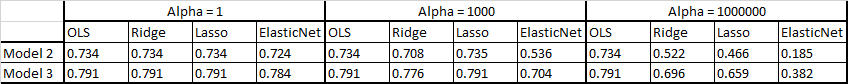
